# VAMPNets

For users already familiar with the VAMPNets interface: The corresponding [API docs](../api/generated/deeptime.decomposition.VAMPNet.rst#deeptime.decomposition.VAMPNet).

VAMPNets <cite data-cite="nbvampnets-mardt2018vampnets">(Mardt, 2018)</cite> are a deep learning approach that try to find transformations $\chi_0$ and $\chi_1$ parameterized by neural networks which optimize a [VAMP](./vamp.ipynb) score <cite data-cite="nbvampnets-wu2020variational">(Wu, 2020)</cite>. These networks therefore can yield transformations of input data so that the featurization is optimal, i.e., the approximation of the Koopman operator is best.

In [1]:
import numpy as np

import deeptime as dt

Working with VAMPNets requires a working installation of [PyTorch](https://pytorch.org/).

In [2]:
import torch
import torch.nn as nn

device = torch.device("cuda")
torch.backends.cudnn.benchmark = True
torch.set_num_threads(12)

Our test system is the [sqrt model](../api/generated/deeptime.data.sqrt_model.rst). It is a hidden two-state jump process with a two-dimensional observable emission distribution so that the two states cannot be linearly separated.

In [3]:
dtraj, traj = dt.data.sqrt_model(n_samples=10000)

Here, `dtraj` are the discrete reference states and `traj` is the observable trajectory:

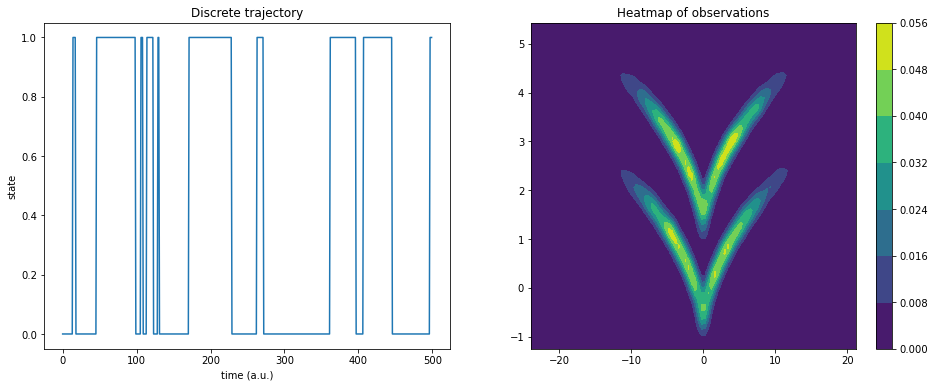

In [4]:
import scipy.stats as stats
import matplotlib.pyplot as plt

X, Y = np.meshgrid(
    np.linspace(np.min(traj[:, 0]), np.max(traj[:, 0]), 100), 
    np.linspace(np.min(traj[:, 1]), np.max(traj[:, 1]), 100),
)
kde_input = np.dstack((X, Y)).reshape(-1, 2)

kernel = stats.gaussian_kde(traj.T, bw_method=.1)
Z = kernel(kde_input.T).reshape(X.shape)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(dtraj[:500])
ax1.set_title('Discrete trajectory')
ax1.set_xlabel('time (a.u.)')
ax1.set_ylabel('state')

cm = ax2.contourf(X, Y, Z)
plt.colorbar(cm, ax=ax2);
ax2.set_title('Heatmap of observations');

In order to work with the VAMPNet / PyTorch API it can be convenient to first convert the trajectory into a [time-lagged dataset](../api/generated/deeptime.data.TimeLaggedDataset.rst).

In [5]:
dataset = dt.data.TimeLaggedDataset.from_trajectory(lagtime=1, data=traj.astype(np.float32))

We now can split data into train and validation set, move the validation set into a torch tensor and onto the appropriate device.

In [6]:
n_val = int(len(dataset)*.3)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

In order to define the transformations $\chi_0$ and $\chi_1$, in principle any PyTorch module can be used. Deeptime offers pre-defined multilayer perceptrons for that purpose. If not specified otherwise, it is assumed that $\chi_0 = \chi_1$ and parameters are shared.

In [7]:
from deeptime.util.torch import MLP
lobe = MLP(units=[traj.shape[1], 15, 10, 10, 5, 1], nonlinearity=nn.ReLU)

Now a VAMPNet instance can be created. For the full range of possible arguments, please see the API docs.

In [8]:
vampnet = dt.decomposition.VAMPNet(lobe=lobe, learning_rate=1e-3)

In order to train it, data loaders must be created for the data sets:

In [9]:
from torch.utils.data import DataLoader

loader_train = DataLoader(train_data, batch_size=512, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

In [10]:
model = vampnet.fit(loader_train, n_epochs=80, validation_loader=loader_val).fetch_model()

We can visualize the progression of the training:

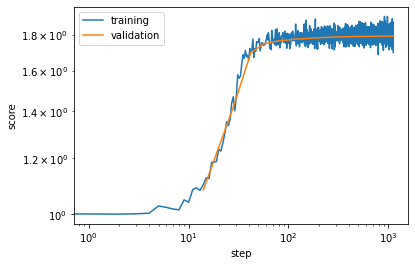

In [11]:
plt.loglog(*vampnet.train_scores.T, label='training')
plt.loglog(*vampnet.validation_scores.T, label='validation')
plt.xlabel('step')
plt.ylabel('score')
plt.legend();

Transforming and plotting the trajectory reveals a featurization in which the two states are nicely disentangled:

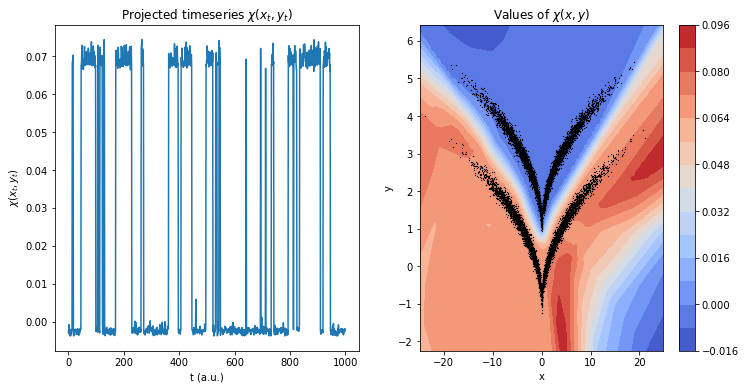

In [12]:
feat = model.transform(traj)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_title(r'Projected timeseries $\chi(x_t, y_t)$')
ax1.plot(feat[:1000])
ax1.set_xlabel('t (a.u.)')
ax1.set_ylabel(r'$\chi(x_t, y_t)$')

xmax = np.max(np.abs(traj[:, 0]))
ymin = np.min(traj[:, 1])
ymax = np.max(traj[:, 1])
grid = np.meshgrid(np.linspace(-xmax-1, xmax+1, 150), np.linspace(ymin-1, ymax+1, 50))
xy = np.dstack(grid).reshape(-1, 2)
z = model.transform(xy)

ax2.set_title(r'Values of $\chi(x,y)$')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
cb = ax2.contourf(grid[0], grid[1], z.reshape(grid[0].shape), levels=15, cmap='coolwarm')
ax2.scatter(*traj.T, s=.1, color='black', marker='x')
plt.colorbar(cb, ax=ax2);

Comparing to a direct evaluation of [VAMP](vamp.ipynb), one can see that the the projection disentangles the process better when using the trained transformation - mainly due to the states not being linearly separable and VAMP being a linear method.

In [13]:
vamp_model_vnet = dt.decomposition.VAMP(lagtime=1).fit(feat).fetch_model()
vamp_model_direct = dt.decomposition.VAMP(lagtime=1, dim=1).fit(traj).fetch_model()

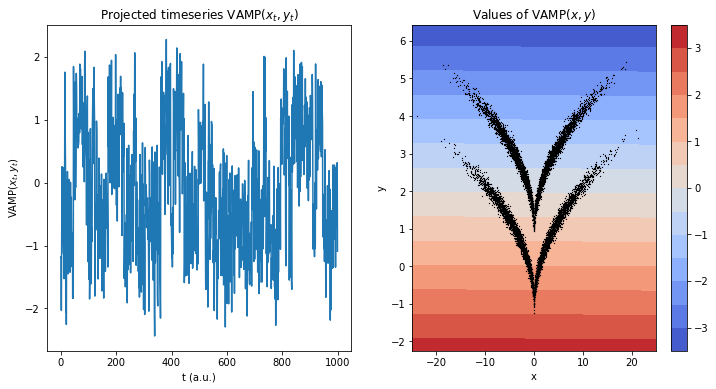

In [14]:
feat = model.transform(traj)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_title(r'Projected timeseries $\mathrm{VAMP}(x_t, y_t)$')
ax1.plot(vamp_model_direct.transform(traj)[:1000])
ax1.set_xlabel('t (a.u.)')
ax1.set_ylabel(r'$\mathrm{VAMP}(x_t, y_t)$')

z = vamp_model_direct.transform(xy)
ax2.set_title(r'Values of $\mathrm{VAMP}(x,y)$')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
cb = ax2.contourf(grid[0], grid[1], z.reshape(grid[0].shape), levels=15, cmap='coolwarm')
ax2.scatter(*traj.T, s=.1, color='black', marker='x')
plt.colorbar(cb, ax=ax2);

This is also reflected in the score:

In [15]:
print(f'VAMPNet score {vamp_model_vnet.score():.5f}')
print(f'Direct VAMP score {vamp_model_direct.score():.5f}')

VAMPNet score 1.80263
Direct VAMP score 1.27069


From here, e.g., a [MSM](../index_msm.rst) could be estimated to systematically analyze the kinetic properties of the system.

In [16]:
projection = vamp_model_vnet.transform(feat)
dtraj_rec = dt.clustering.Kmeans(2).fit(projection).transform(projection)
msm = dt.markov.msm.MaximumLikelihoodMSM().fit(dtraj_rec, lagtime=1).fetch_model()

The estimated transition matrix fits with the hidden transition matrix that generated the data

In [17]:
print("estimated transition matrix", msm.transition_matrix)

estimated transition matrix [[0.94757163 0.05242837]
 [0.0508074  0.9491926 ]]
